In [6]:
import geopandas as gpd
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
from shapely.geometry import Point, Polygon
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import descartes
import math
import matplotlib.colors as mcolors
import pyproj
import folium

path

In [7]:
# Setting
wdir = "../Dades/AMS_Observacions/"
crs_latlon = 'EPSG:4326'  # WGS84
crs_utm = "EPSG:32631"   # UTM zone 31

In [ ]:
# Cargar el shapefile
archivo_shapefile = "../Dades/OpenTransportMap/Barcelona/roadlinks_ES511.shp"
gdf_barcelona = gpd.read_file(archivo_shapefile)
gdf_girona = gpd.read_file("../Dades/OpenTransportMap/Girona/roadlinks_ES512.shp")
gdf_lleida = gpd.read_file("../Dades/OpenTransportMap/Lleida/roadlinks_ES513.shp")
gdf_tarragona = gpd.read_file("../Dades/OpenTransportMap/Tarragona/roadlinks_ES514.shp")

# Concatenate the GeoDataFrames
gdf = pd.concat([gdf_barcelona, gdf_girona, gdf_lleida, gdf_tarragona], ignore_index=True)
# Mostrar las primeras filas de la tabla de atributos
#print(gdf['functional'].head())

# Obtener los tipos únicos de la columna 'functional'
tipos_functional = gdf['functional'].unique()

# Asignar valores de prioridad a las categorías
valores_prioridad = {
    'mainRoad': 6 / 6,
    'firstClass': 5 / 6,
    'secondClass': 4 / 6,
    'thirdClass': 3 / 6,
    'fourthClass': 2 / 6,
    'fifthClass': 1 / 6,    
}

# Crear una nueva columna en el GeoDataFrame con los valores de prioridad
gdf['prioridad'] = gdf['functional'].map(valores_prioridad)

# Crear un nuevo DataFrame con las columnas 'sourceid', 'functional' y 'prioridad'
df_transport = gdf[['sourceid', 'prioridad','geometry']].drop_duplicates().reset_index(drop=True)

print(df_transport.head())

# Guardar el GeoDataFrame en un archivo CSV
#gdf.to_csv("./carreteres.csv", index=False)


0     fifthClass
1    fourthClass
2    fourthClass
3     fifthClass
4     fifthClass
Name: functional, dtype: object


In [4]:
# Assuming the CSV file is located in the directory specified by wdir
csv_file_path = wdir + 'XVPCA_info_sconcno2_2023.csv'

df_obs = pd.read_csv(csv_file_path)

df_no2 = pd.read_csv(wdir + 'gene_sconcno2_2023_xvpca_emep_port.csv')
df_obs['geometry'] = gpd.points_from_xy(df_obs['lon'], df_obs['lat'], crs=crs_utm)

df_copy = df_obs.copy()
# Add a new column to df_obs to store the last value from df_no2 for each id
# Create a new DataFrame with only the rows where 'no2_value' is NaN
df_obs['no2_value'] = df_obs['code'].apply(lambda x: df_no2[x].mean() if x in df_no2.columns else np.nan)
df_obs = df_obs.dropna(subset=['no2_value'])

# Crear un DataFrame con los códigos que están en df_copy pero no en df_obs
df_na = df_copy[~df_copy['code'].isin(df_obs['code'])]

# Mostrar los primeros registros del DataFrame resultante
#print(df_na.head())

print(df_obs.head())

      code        lat       lon            type              geometry  \
0      ZAL  41.317277  2.134501    urban-centre  POINT (2.135 41.317)   
1  ES0010R  42.319174  3.315828        F – Fons  POINT (3.316 42.319)   
2  ES0014R  41.393887  0.734722        F – Fons  POINT (0.735 41.394)   
3  ES0584A  41.482016  2.188297  urban-suburban  POINT (2.188 41.482)   
4  ES0691A  41.403716  2.204736    urban-centre  POINT (2.205 41.404)   

   no2_value  
0  22.744536  
1   2.885103  
2   2.537266  
3  31.528801  
4  24.297369  


In [4]:
np.random.seed(1)
pick_random_points = np.random.choice(len(df_obs), size=min(1000, len(df_obs)), replace=False)
input_data_example = df_obs.iloc[pick_random_points]

In [5]:
domain_polygon = gpd.read_file('../Dades/Hands-on_Downscaling/Data_python/def_domini_bcn.geojson')

# Obtener los límites del dominio
minx, miny, maxx, maxy = domain_polygon.total_bounds

# Crear una cuadrícula de 20m x 20m
x_coords = np.arange(minx, maxx, 20)
y_coords = np.arange(miny, maxy, 20)

# Generar puntos en cada celda de la cuadrícula
points = [Point(x, y) for x in x_coords for y in y_coords]

# Crear un GeoDataFrame con los puntos
grid = gpd.GeoDataFrame(points, columns=['geometry'], crs=domain_polygon.crs)

# Filtrar los puntos que están dentro del dominio
grid = grid[grid.within(domain_polygon.unary_union)]

# Convertir las coordenadas a latitud y longitud (WGS84)
grid = grid.to_crs(crs_latlon)

# Mostrar los primeros puntos generados
print(grid.head())

C:\Users\11ser\AppData\Local\Temp\ipykernel_15460\1893964595.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid = grid[grid.within(domain_polygon.unary_union)]


                              geometry
855  POINT (420699.71839 4574405.3613)
856  POINT (420699.71839 4574425.3613)
857  POINT (420699.71839 4574445.3613)
858  POINT (420699.71839 4574465.3613)
859  POINT (420699.71839 4574485.3613)


In [6]:
ok = OrdinaryKriging(
    input_data_example.geometry.apply(lambda geom: geom.x), 
    input_data_example.geometry.apply(lambda geom: geom.y), 
    input_data_example['no2_value'].values,
    variogram_model='gaussian',
    verbose=True, 
    enable_plotting=False,
    nlags=25
)


Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 43.91663997938365
Full Sill: 67.93806181256198
Range: 0.4084263393672743
Nugget: 24.021421833178323 

Calculating statistics on variogram model fit...


Executing Ordinary Kriging...



C:\Users\11ser\AppData\Local\Temp\ipykernel_15460\2659620909.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na['kriging_prediction'] = z_na
C:\Users\11ser\AppData\Local\Temp\ipykernel_15460\2659620909.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na['kriging_variance'] = ss_na


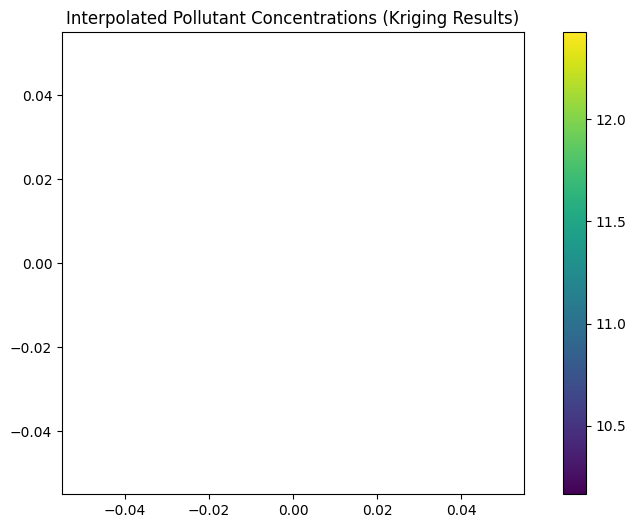

In [18]:
# Perform the interpolation
#z, ss = ok.execute('points', grid.geometry.apply(lambda geom: geom.x), grid.geometry.apply(lambda geom: geom.y))
# Perform the interpolation for df_na
z_na, ss_na = ok.execute('points', df_na.geometry.apply(lambda geom: geom.x), df_na.geometry.apply(lambda geom: geom.y))

# Add the interpolation results to df_na
df_na['kriging_prediction'] = z_na
df_na['kriging_variance'] = ss_na

# Añadir los resultados de la interpolación al GeoDataFrame de la cuadrícula
#grid['kriging_prediction'] = z
#grid['kriging_variance'] = ss

# Convertir a Web Mercator para la visualización
grid_webmercator = grid.to_crs(epsg=3857)

# Plotting the Kriging results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
grid_webmercator.plot(column='kriging_prediction', ax=ax, legend=True, cmap='viridis', edgecolor='k')

# Add contextily basemap (Web Mercator)
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title and labels
ax.set_title('Interpolated Pollutant Concentrations (Kriging Results)')
plt.show()

In [23]:
# Create a copy and convert to the correct CRS for folium (WGS84)
df_obs_wgs84 = df_obs.copy().to_crs(epsg=4326)

# Extract lat and lon for folium
df_obs_wgs84['lon'] = df_obs_wgs84.geometry.x
df_obs_wgs84['lat'] = df_obs_wgs84.geometry.y

# Create a colormap
norm = mcolors.Normalize(vmin=df_obs_wgs84['kriging_prediction'].min(), vmax=df_obs_wgs84['kriging_prediction'].max())
cmap = plt.cm.viridis

# Create a folium map centered around the data
map_center = [df_obs_wgs84['lat'].mean(), df_obs_wgs84['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Add circle markers for each observation location with color based on kriging prediction
for idx, row in df_obs_wgs84.iterrows():
    color = mcolors.to_hex(cmap(norm(row['kriging_prediction'])))
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Pollutant: {row['kriging_prediction']:.2f}"
    ).add_to(m)

# Save the map to an HTML file and display it
#m.save('map.html')



AttributeError: 'DataFrame' object has no attribute 'to_crs'